In [2]:
from pruneshift.datamodules import ShiftDataModule
from pruneshift.networks import create_network
from pruneshift.teachers import create_teacher
from pruneshift.teachers import Teacher
from crd.criterion import CRDLoss
from pathlib import Path

import random
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import os
import numpy as np
from omegaconf import OmegaConf
from pytorch_lightning.metrics.functional import accuracy


combined = "/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/combined"

imgr_tag = "ImageNet100-R Error"
imgc_tag = "ImageNet100-C Error"
img_tag = "ImageNet100 Error"

In [123]:
exp_folders = list(Path(combined).glob("*/[0-9]*/"))

In [124]:
def teacher_name(conf):
    if conf.teacher.name == "swsl_resnet50":
        return conf.teacher.name
    elif conf.teacher.name == "resnet50":
        if conf.teacher.ckpt_path is None:
            return "std_resnet50"
        return "amda_resnet50"
    raise NotImplementedError

def build_df(path):
    df = pd.read_csv(path / "metrics.csv").iloc[-1: ].filter(regex="test_*")
    conf = OmegaConf.load(path / "configs.yaml")
    df["Prune Method"] = conf.prune.method
    df["Prune Amount"] = conf.prune.amount
    df["Student"] = conf.network.name
    df["Teacher"] = teacher_name(conf)
    df["amda"] = conf.datamodule.augmix

    if "test_acc_clean" in df.columns:
        df[img_tag] = 1 - df["test_acc_clean"]

    if "test_mCE" in df.columns:
        df[imgc_tag] = df["test_mCE"]

    if "test_acc_rendition" in df.columns:
        df[imgr_tag] = 1 - df["test_acc_rendition"]

    return df

In [125]:
df = pd.concat([build_df(p) for p in exp_folders], sort=True)

<AxesSubplot:xlabel='ImageNet100 Error', ylabel='ImageNet100-R Error'>

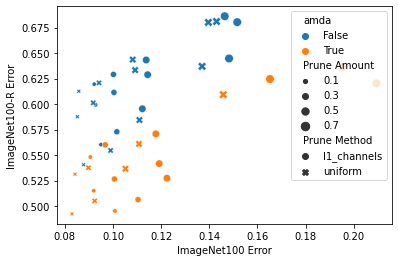

In [131]:
sns.scatterplot(data=df, x=img_tag, y=imgr_tag, hue="amda", style="Prune Method", size="Prune Amount")

<AxesSubplot:xlabel='ImageNet100-R Error', ylabel='ImageNet100-C Error'>

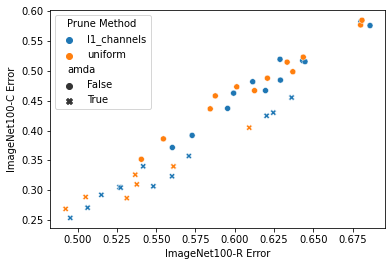

In [132]:
sns.scatterplot(data=df, x=imgr_tag, y=imgc_tag, hue="Prune Method", style="amda")

<AxesSubplot:xlabel='ImageNet100 Error', ylabel='ImageNet100-C Error'>

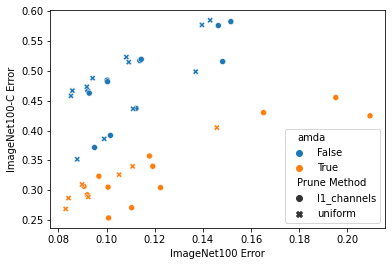

In [128]:
sns.scatterplot(data=df, x=img_tag, y=imgc_tag, hue="amda", style="Prune Method")

<AxesSubplot:xlabel='ImageNet100 Error', ylabel='ImageNet100-C Error'>

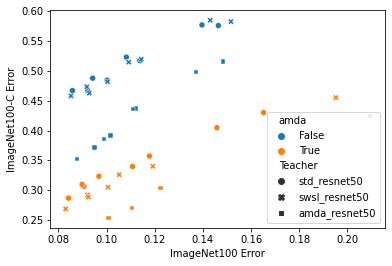

In [129]:
sns.scatterplot(data=df, x=img_tag, y=imgc_tag, hue="amda", style="Teacher")

<AxesSubplot:xlabel='ImageNet100-C Error', ylabel='ImageNet100-R Error'>

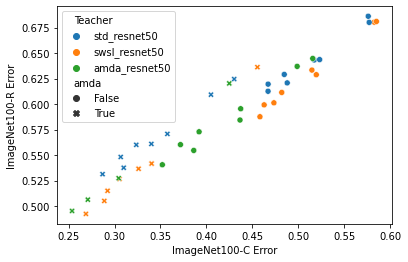

In [134]:
sns.scatterplot(data=df, x=imgc_tag, y=imgr_tag, hue="Teacher", style="amda")